/var/folders/_k/7gb911zx6tnfp1fvl5kc1p500000gn/T/ipykernel_58656/1974497633.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = df.groupby('label').apply(lambda grp: grp.sample(1, random_state=42))


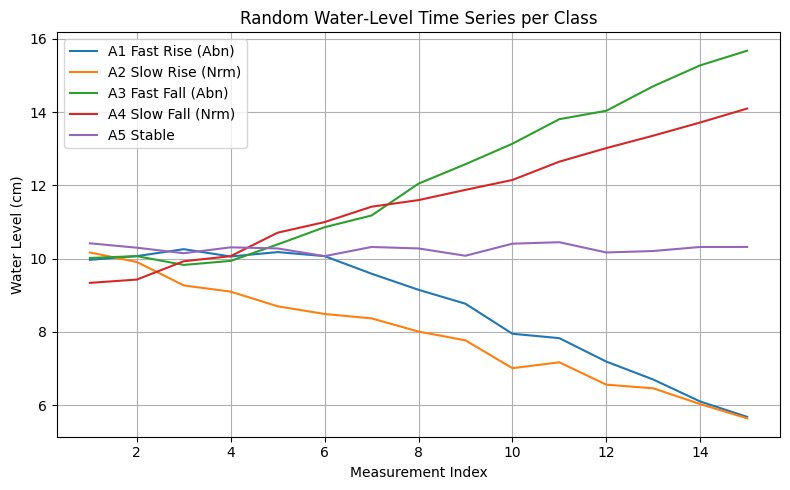

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('final_dataset.csv')

# Feature columns (assumes last column is 'label')
features = df.columns[:-1]

# Mapping from label to class names
label_names = {
    0: "A1 Fast Rise (Abn)",
    1: "A2 Slow Rise (Nrm)",
    2: "A3 Fast Fall (Abn)",
    3: "A4 Slow Fall (Nrm)",
    4: "A5 Stable"
}

# Select one random sample per class
samples = df.groupby('label').apply(lambda grp: grp.sample(1, random_state=42))
# After `groupby.apply` the index will be a MultiIndex; reset it:
samples = samples.reset_index(drop=True)

# Plot all time series on one graph
plt.figure(figsize=(8, 5))
for _, row in samples.iterrows():
    lbl = int(row['label'])
    values = row[features].astype(float).values
    plt.plot(range(1, len(values) + 1), values, label=label_names[lbl])

plt.title("Random Water‑Level Time Series per Class")
plt.xlabel("Measurement Index")
plt.ylabel("Water Level (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1760 - loss: 1.7667 - val_accuracy: 0.0417 - val_loss: 1.9533 - learning_rate: 0.0010
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1795 - loss: 1.7830 - val_accuracy: 0.0417 - val_loss: 1.8892 - learning_rate: 0.0010
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1577 - loss: 1.7111 - val_accuracy: 0.0833 - val_loss: 1.8286 - learning_rate: 0.0010
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1466 - loss: 1.8062 - val_accuracy: 0.1250 - val_loss: 1.7740 - learning_rate: 0.0010
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2182 - loss: 1.7302 - val_accuracy: 0.0833 - val_loss: 1.7238 - learning_rate: 0.0010
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1924 - loss: 1.6802 - val_accuracy: 0.0833 - val_loss: 1.6762 - learning_rate: 0.0010
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2894 - loss: 1.6141 - val_accuracy: 0.1250

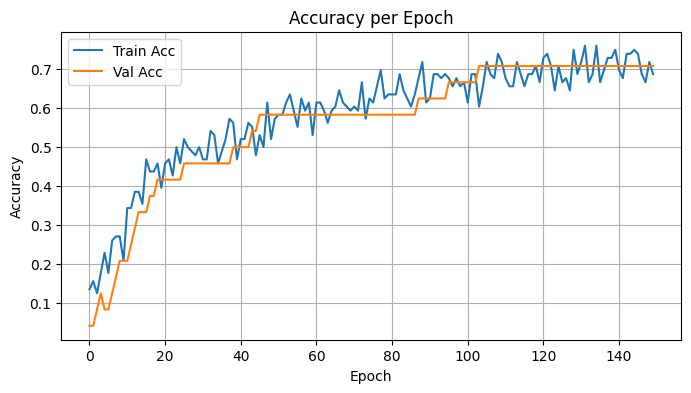

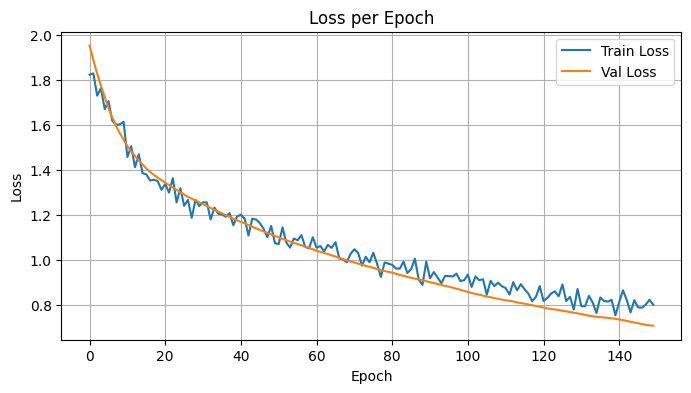

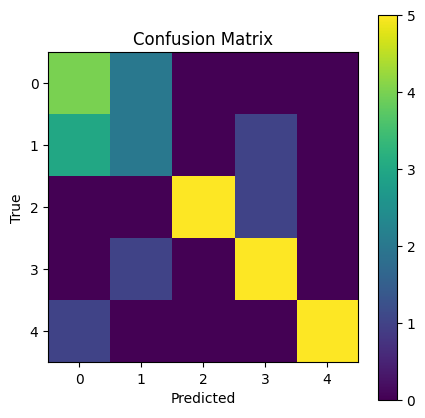

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv('final_dataset.csv')
X = df.drop('label', axis=1).values
y = df['label'].values

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4. Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),
    tf.keras.layers.Dense(16, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# 5. Callbacks
cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# 6. Train
history = model.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.2,
    callbacks=cbs,
    verbose=1
)

# 7. Evaluate
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

# 8. Confusion matrix
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# 9. Plot metrics
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.show()


In [2]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("water_level_model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ TFLite model saved to water_level_model.tflite")

INFO:tensorflow:Assets written to: /var/folders/_k/7gb911zx6tnfp1fvl5kc1p500000gn/T/tmpzkoh8k53/assets


INFO:tensorflow:Assets written to: /var/folders/_k/7gb911zx6tnfp1fvl5kc1p500000gn/T/tmpzkoh8k53/assets


Saved artifact at '/var/folders/_k/7gb911zx6tnfp1fvl5kc1p500000gn/T/tmpzkoh8k53'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  5407529808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5407530768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5407532112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5407530000: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved to water_level_model.tflite


W0000 00:00:1746383507.467303  158675 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746383507.467316  158675 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-05 01:31:47.467607: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/_k/7gb911zx6tnfp1fvl5kc1p500000gn/T/tmpzkoh8k53
2025-05-05 01:31:47.467801: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-05 01:31:47.467807: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/_k/7gb911zx6tnfp1fvl5kc1p500000gn/T/tmpzkoh8k53
I0000 00:00:1746383507.469137  158675 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-05-05 01:31:47.469370: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-05 01:31:47.477027: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder